# Compare predictions
This notebook includes a comparison between the predictions of the hydroestimator, the cnn and the mlp on the rain gauge data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap
from matplotlib import cm
import copy
import torch
import xarray as xr
import pandas as pd
import os
import datetime

import cartopy
import cartopy.crs as ccrs
from pyresample import load_area, geometry

import quantnn

import sys
sys.path.append('../visualize')
import plotTestSetup as setup
from plotTest import plotFalse, plotError, plotDistribution, hist2D

### Settings 

In [2]:
#data path
f = open('../path_to_data.txt', "r")
path_to_dataset = os.path.join(f.readline().rstrip("\n"))
f.close() 

In [3]:
#load dataset
combined_all = xr.open_dataset(os.path.join(path_to_dataset,'combined.nc'))
combined_all

<xarray.Dataset>
Dimensions:                  (location: 609, time: 738)
Coordinates:
  * location                 (location) int64 0 1 2 3 4 ... 604 605 606 607 608
  * time                     (time) datetime64[ns] 2020-12-01T01:00:00 ... 20...
Data variables:
    xception_posterior_mean  (time, location) float32 ...
    xception_Q0.95           (time, location) float32 ...
    xception_Q0.99           (time, location) float32 ...
    mlp_posterior_mean       (time, location) float32 ...
    mlp_Q0.95                (time, location) float32 ...
    mlp_Q0.99                (time, location) float32 ...
    HE_precip                (time, location) float64 ...
    HE_precip_corr           (time, location) float64 ...
    gauge_precip             (time, location) float64 ...

### Metadata

In [4]:
#load metadata
metadata = pd.read_pickle(os.path.join(path_to_dataset, 'real_rain_gauge_data', 'general_rain_gauge_info.pckl'))

In [5]:
#metadata[(metadata.lon< -43.2) & (metadata.lat< 22.5) & (metadata.state=='RJ')] #429

### NaNs

In [6]:
print('NaNs in gauges:', np.isnan(combined_all.gauge_precip.values).sum())
print('NaNs in HE:', np.isnan(combined_all.HE_precip.values).sum())
print('NaNs in HE corr:', np.isnan(combined_all.HE_precip_corr.values).sum())
print('NaNs in MLP:', np.isnan(combined_all.mlp_posterior_mean.values).sum())
print('NaNs in CNN:', np.isnan(combined_all.xception_posterior_mean.values).sum())

NaNs in gauges: 165555
NaNs in HE: 6090
NaNs in HE corr: 6090
NaNs in MLP: 1759
NaNs in CNN: 1759


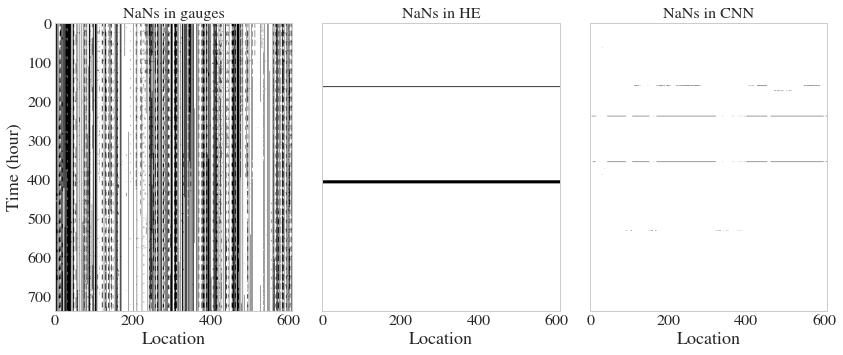

In [7]:
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=setup.figsize_two_cols)
data = combined_all.gauge_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax[0].imshow(m, cmap='binary')
ax[0].set_xlabel('Location')
ax[0].set_ylabel('Time (hour)')
ax[0].set_title('NaNs in gauges')
ax[0].grid(False)

data = combined_all.HE_precip.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax[1].imshow(m, cmap='binary')
ax[1].set_xlabel('Location')
ax[1].set_title('NaNs in HE')
ax[1].grid(False)

data = combined_all.xception_posterior_mean.values
m = np.zeros((data.shape[0], data.shape[1]))
m[np.isnan(data)] = 1
ax[2].imshow(m, cmap='binary')
ax[2].set_xlabel('Location')
ax[2].set_title('NaNs in CNN')
ax[2].grid(False)

plt.tight_layout()

In [8]:
mask = np.zeros((combined_all.gauge_precip.values.shape[0], combined_all.gauge_precip.values.shape[1]))
mask[np.isnan(combined_all.gauge_precip.values)] = 1
mask[np.isnan(combined_all.HE_precip.values)] = 1
mask[np.isnan(combined_all.xception_posterior_mean.values)] = 1

print('missing values fraction:', mask.sum()/len(mask.flatten()))

missing values fraction: 0.3793793192447524


In [9]:
# Make sure that comparison is done only where values are present in all datasets.
combined = combined_all.copy()
combined = combined.where(mask==0)

### Gauges

In [10]:
#Explore properties of reference data
dat = combined.gauge_precip.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat))
start = -0.1
end = 83.3
binsize = 0.2
num_of_bins = int(np.round((end-start)/binsize)+1)
bins = np.linspace(start,end,num_of_bins)
#print('matching bins:', bins)

unique values in gauge data: [ 0.   0.2  0.4  0.6  0.8  1.   1.2  1.4  1.6  1.8  2.   2.2  2.4  2.6
  2.8  3.   3.2  3.4  3.6  3.8  4.   4.2  4.4  4.6  4.8  5.   5.2  5.4
  5.6  5.8  6.   6.2  6.4  6.6  6.8  7.   7.2  7.4  7.6  7.8  8.   8.2
  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10.  10.2 10.4 10.6 10.8 11.
 11.2 11.4 11.6 11.8 12.  12.2 12.4 12.6 12.8 13.  13.2 13.4 13.6 13.8
 14.  14.2 14.4 14.6 14.8 15.  15.2 15.4 15.6 15.8 16.  16.2 16.4 16.6
 16.8 17.  17.2 17.4 17.6 17.8 18.  18.2 18.4 18.6 18.8 19.  19.2 19.4
 19.6 19.8 20.  20.2 20.4 20.6 20.8 21.  21.2 21.4 21.6 21.8 22.  22.2
 22.4 22.6 22.8 23.  23.2 23.4 23.6 23.8 24.  24.2 24.4 24.6 24.8 25.
 25.2 25.4 25.6 25.8 26.  26.2 26.4 26.6 26.8 27.  27.2 27.4 27.6 27.8
 28.  28.2 28.4 28.6 28.8 29.  29.2 29.4 29.6 29.8 30.  30.2 30.4 30.6
 30.8 31.  31.4 31.6 32.  32.2 32.4 32.6 33.2 33.6 33.8 34.  34.4 34.6
 34.8 35.  35.2 35.4 35.6 35.8 36.  36.2 36.4 36.6 36.8 37.  37.2 37.6
 38.4 38.6 38.8 39.  39.2 39.6 39.8 40.2 40.4 40.6

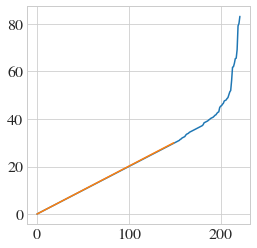

In [11]:
fig, ax = plt.subplots(figsize=(4,4))
ax.plot(np.unique(dat))
#plt.yscale('log')
ax.plot([0,149], [0,30])

### Scalar metrics

In [12]:
def Bias(a,b,dataset,mask):
    bias = np.mean(np.subtract(dataset[b].values, dataset[a].values)[mask==0])
    return(bias)

def MAE(a,b,dataset,mask):
    mae = np.mean(np.abs(np.subtract(dataset[b].values, dataset[a].values)[mask==0]))
    return(mae)

def MSE(a,b,dataset,mask):
    mse = np.mean(np.square(np.subtract(dataset[b].values, dataset[a].values)[mask==0]))
    return(mse)

#### Bias

In [13]:
print('HE:',Bias('gauge_precip','HE_precip',combined,mask))
print('HE corr:',Bias('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',Bias('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',Bias('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.1041845413295188
HE corr: -0.006546504557844834
MLP: -0.02128214204459453
CNN: 0.004233128358052377


#### MAE

In [14]:
print('HE:',MAE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MAE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MAE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MAE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 0.39354618014600884
HE corr: 0.3000981773968421
MLP: 0.26460390683247
CNN: 0.23152983903431412


#### MSE

In [15]:
print('HE:',MSE('gauge_precip','HE_precip',combined,mask))
print('HE corr:',MSE('gauge_precip','HE_precip_corr',combined,mask))
print('MLP:',MSE('gauge_precip','mlp_posterior_mean',combined,mask))
print('CNN:',MSE('gauge_precip','xception_posterior_mean',combined,mask))

HE: 3.9399494848424386
HE corr: 2.4381287135261074
MLP: 2.03985636993056
CNN: 1.698436812975142


### Histograms 

In [23]:
#Extract for plotting
data_dict = {}
quantity = 'precipitation (mm)'
data_list = ['gauge_precip', 'HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean']
for var in data_list:
    data_dict[var] = combined[var].values[mask==0].flatten()

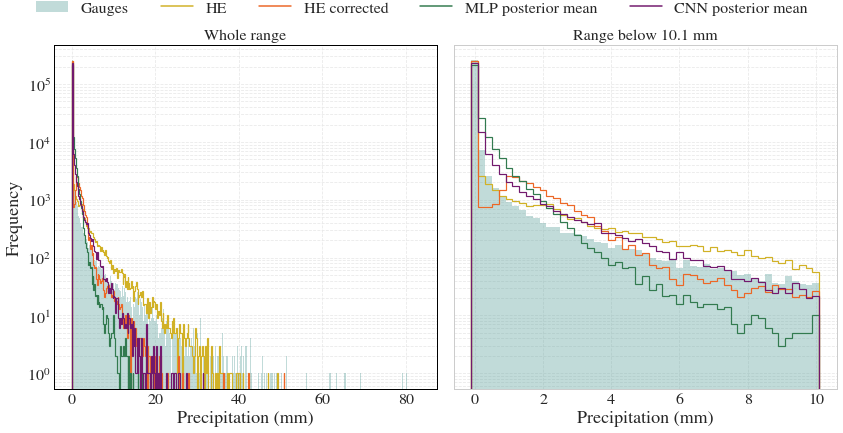

In [27]:
var_list = ['HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean']
plotDistribution(data_dict, bins, 'gauge_precip', 
                 ['HE_precip', 'HE_precip_corr', 'mlp_posterior_mean', 'xception_posterior_mean'],
                quantity=quantity
                )

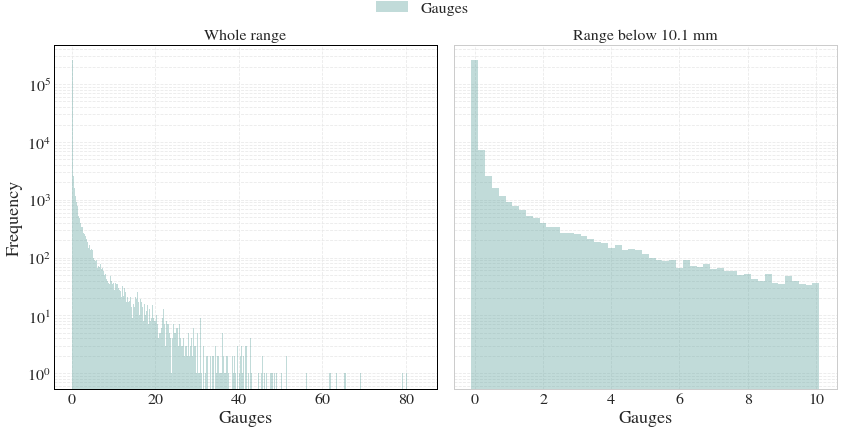

In [28]:
plotDistribution(data_dict, bins, 'gauge_precip', 
                 [],
                #save=True
                )

### Error

In [29]:
start_diff = -83.1 #np.floor(np.min([np.min(diff_HE_corr), np.min(diff_CNN)]))
print(start_diff)
end_diff = 51.1 #np.ceil(np.max([np.max(diff_HE_corr), np.max(diff_CNN)]))
print(end_diff)
binsize_diff = 0.1
diffbins = np.linspace(start_diff,end_diff,int(np.round((end_diff-start_diff)/binsize_diff))+1)
print(diffbins)

-83.1
51.1
[-83.1 -83.  -82.9 ...  50.9  51.   51.1]


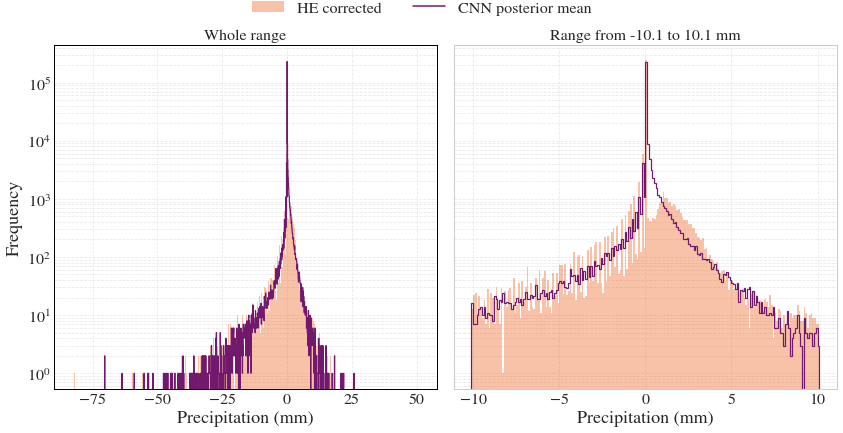

In [30]:
var_list = ['HE_precip_corr', 'xception_posterior_mean']
plotError(data_dict, diffbins, 'gauge_precip', var_list, quantity=quantity)

### Classes

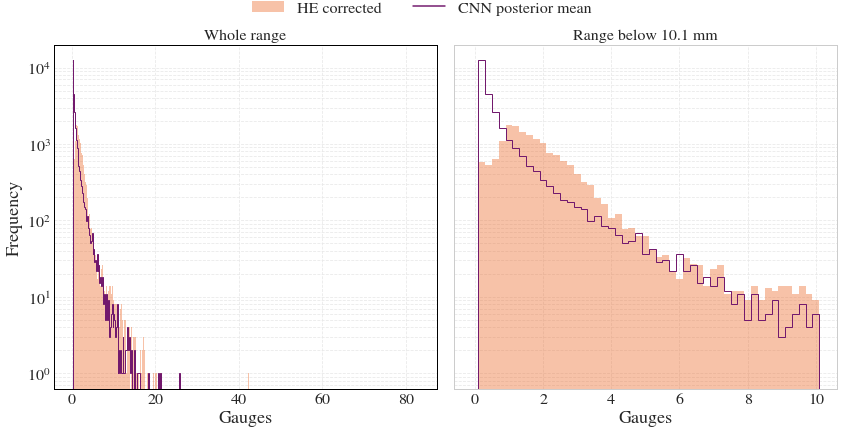

In [31]:
plotFalse(data_dict, bins, 'gauge_precip', 
                 ['HE_precip_corr', 'xception_posterior_mean'], ty='FP',
                )

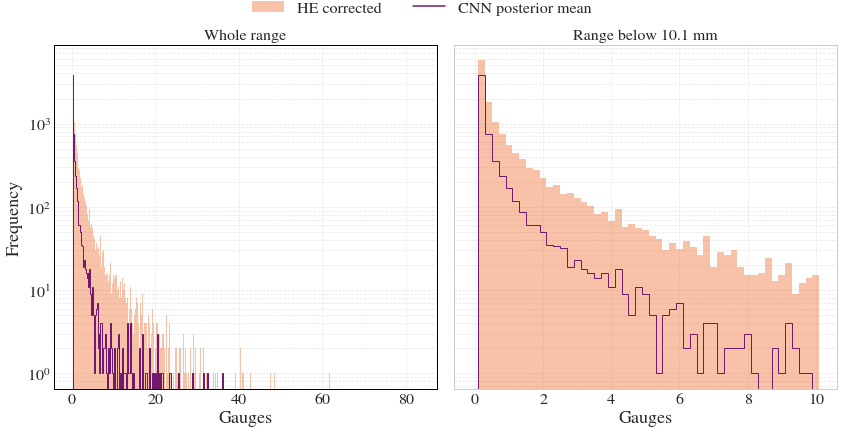

In [32]:
plotFalse(data_dict, bins, 'gauge_precip', 
                 ['HE_precip_corr', 'xception_posterior_mean'], ty='FN',
                )

In [33]:
def Classification(y,p, threshold=1e-1):

    TP = (p[y>threshold]>threshold).sum() #Is rain, predict rain
    TN = (p[y<=threshold]<=threshold).sum() #Is no rain, predict no rain
    FP = (p[y<=threshold]>threshold).sum() #Is no rain, predict rain
    FN = (p[y>threshold]<=threshold).sum() #Is rain, predict no rain

    '''
    fig, ax = plt.subplots()
    confusion_matrix = np.array([[FP, TP], [TN, FN]])#np.array([[TP, FN], [FP, TN]])
    m = ax.imshow(confusion_matrix, cmap='Greens')
    ax.set_ylabel('Predicted class')
    ax.set_xlabel('True class')
    ax.grid(False)
    ax.set_xticks(ticks=[0,1])
    ax.set_xticklabels(labels=['No rain', 'Rain',])
    ax.set_yticks(ticks=[1,0])
    ax.set_yticklabels(labels=['No rain', 'Rain'])
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.07)
    plt.colorbar(m, cax=cax)
    
    # Loop over data dimensions and create text annotations.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            text = ax.text(j, i, confusion_matrix[i, j],
                           ha="center", va="center", color="orange", fontsize=18)
    plt.show()
    '''
    
    #print('TP, Is rain, predict rain:', TP)
    #print('TN, Is no rain, predict no rain:', TN)
    #print('FP, Is no rain, predict rain:', FP)
    #print('FN, Is rain, predict no rain:', FN)

    TPR = (TP/(TP+FN)) #Sensitivity or Recall (POD=hits/(hits+misses))
    #print('TPR', "{:.2f}".format(TPR))
    TNR = (TN/(TN+FP)) #Specificity
    #print('TPR', "{:.2f}".format(TNR))
    PPV = (TP/(TP+FP)) #Precision
    #print('PPV', "{:.2f}".format(PPV))
    PNV = (TN/(TN+FN))
    #print('PNV', "{:.2f}".format(PNV))

    FAR = (FP/(FP+FN)) #false alarms/(false alarms+hits)
    #print('FAR', "{:.2f}".format(FAR)) 

    CSI = TP/(TP+FN+FP) #hits/(hits+misses+false alarms)
    #print('CSI', "{:.2f}".format(CSI))
    
    FPR = FP/(FP+TN)
    FNR = FN/(FN+TP)
    print('FPR:', FPR)
    print('FNR:', FNR)

In [34]:
th=4e-1#1.9e-1
th

0.4

In [35]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.xception_posterior_mean.values[mask==0].flatten(), threshold=th)

FPR: 0.058947107791462366
FNR: 0.2363401228580666


In [36]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.mlp_posterior_mean.values[mask==0].flatten(),  threshold=th)

FPR: 0.09200145557677229
FNR: 0.27158098933074687


In [37]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.HE_precip_corr.values[mask==0].flatten(),  threshold=th)

FPR: 0.06673519382055139
FNR: 0.5433236340122858


In [38]:
Classification(combined.gauge_precip.values[mask==0].flatten(),
               combined.HE_precip.values[mask==0].flatten(),  threshold=th)

FPR: 0.05570582343253514
FNR: 0.6044293566117038


### 2D histograms

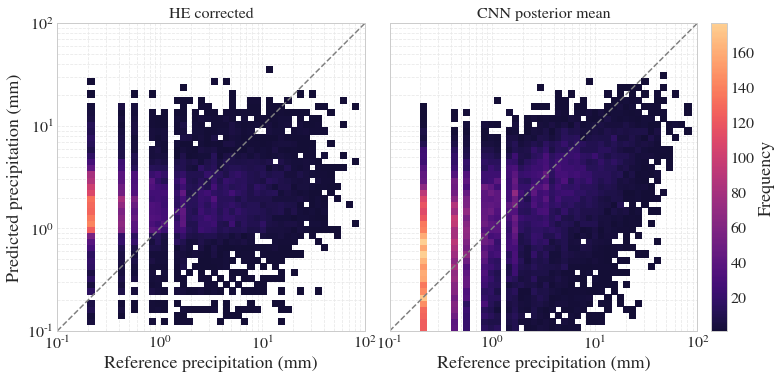

In [39]:
hist2D(data_dict, 'gauge_precip', ['HE_precip_corr', 'xception_posterior_mean'], norm_type=None, quantity=quantity)

0.10032880451640916
0.10032880451640916


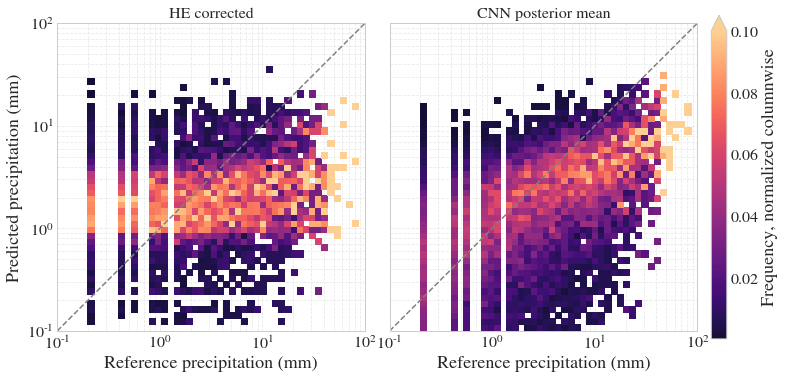

In [40]:
hist2D(data_dict, 'gauge_precip', ['HE_precip_corr', 'xception_posterior_mean'], norm_type='colwise', quantity=quantity)

### Diurnal cycle

In [41]:
import datetime
import timezonefinder, pytz

tf = timezonefinder.TimezoneFinder()

def getTimeZone(lat, lon):
    timezone_str = tf.certain_timezone_at(lat=lat, lng=lon)

    if timezone_str is None:
        print( "Could not determine the time zone")
        return(None)
    else:
        # Assuming same utc offset at given location throughout whole timeperiod Dec 2020
        timezone = pytz.timezone(timezone_str)
        dt = datetime.datetime(2020,12,1)
    return(timezone.utcoffset(dt).total_seconds()/3600.0)

In [42]:
def UTCtoLocal(dataset,mdat):
    shift = []
    for i in mdat.index:
        shift.append(getTimeZone(mdat.lat[i], mdat.lon[i]))
        
    ind_to_shift = []
    for s in np.unique(shift):
        ind_to_shift.append(list(np.where(shift==s)))
        
    di = dataset.copy()
    dj = dataset.copy()
    
    abs_diff = int(np.max(np.abs(np.unique(shift))))
    to_add = dj.time.min()+np.timedelta64(abs_diff,'h')
    
    dj = dj.where(dj.time<to_add, drop=True)
    dj = dj.where(dj.time<di.time.min())
    
    dj = dj.assign_coords(time=di.time[:abs_diff]-np.timedelta64(abs_diff,'h'))
    
    dext = xr.concat([dj, di], "time")
    
    datasets = []
    for i in range(len(np.unique(shift))):
        print(int(np.unique(shift)[i]))
        #print(ind_to_shift[i][0])
        selection = dext.copy().isel(location=ind_to_shift[i][0])
        selection = selection.shift(time=int(np.unique(shift)[i]))
        datasets.append(selection)    
        
    dshifted = xr.concat(datasets, "location")
    dshifted = dshifted.sortby("location")
    
    return(dshifted)

In [43]:
combined_local_time = UTCtoLocal(combined, metadata)

-5
-4
-3
-2


In [44]:
def diurnal_cycle(dataset, xlab='Time (hour)'):
    di = dataset.copy()
    di = di.mean(dim='location')
    di = di.groupby('time.hour')
    st = di.std()
    me = di.mean()

    fig, ax = plt.subplots(figsize=setup.figsize_single_plot)

    ax.plot(me.hour, me.gauge_precip, label=setup.variable_dict['gauge_precip']['label'], color=setup.variable_dict['gauge_precip']['color'])
    ax.plot(me.hour, me.HE_precip_corr, label=setup.variable_dict['HE_precip_corr']['label'], linestyle='dashdot', color=setup.variable_dict['HE_precip_corr']['color'])
    ax.plot(me.hour, me.xception_posterior_mean, label=setup.variable_dict['xception_posterior_mean']['label'], linestyle='dashed', color=setup.variable_dict['xception_posterior_mean']['color'])
    ax.fill_between(me.hour, me.gauge_precip+st.gauge_precip,
                    me.gauge_precip-st.gauge_precip, linestyle='--', alpha=0.1, color=setup.variable_dict['gauge_precip']['color'])
    ax.fill_between(me.hour, me.HE_precip_corr+st.HE_precip_corr, 
                    me.HE_precip_corr-st.HE_precip_corr, alpha=0.1, color=setup.variable_dict['HE_precip_corr']['color'])
    ax.fill_between(me.hour, me.xception_posterior_mean+st.xception_posterior_mean,
                       me.xception_posterior_mean-st.xception_posterior_mean, alpha=0.1, color=setup.variable_dict['xception_posterior_mean']['color'])
    ax.grid(True,which="both",ls="--",c=setup.color_grid)
    ax.set_ylabel(quantity.capitalize())
    ax.set_xlabel(xlab)
    ax.legend(loc='upper left')
    plt.tight_layout()
    #plt.savefig('../plots/thesis/diurnal_cycle_gauge.pdf', bbox_inches='tight')]

In [45]:
#diurnal_cycle(combined)

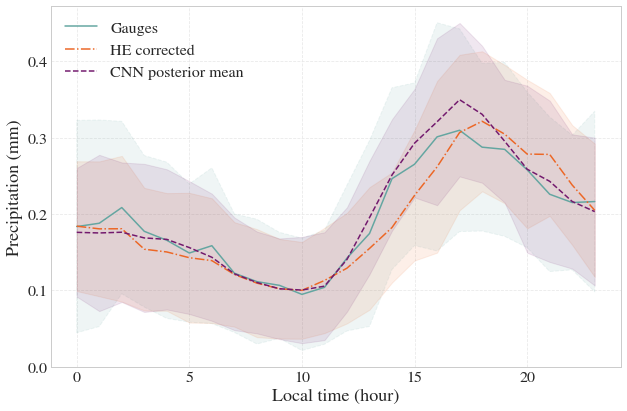

In [46]:
diurnal_cycle(combined_local_time, xlab='Local time (hour)') #time with local utc offset

### Single rain gauge over time

In [47]:

def plotGaugeTimeseries(ind,start=0,end=-1):
    fig, ax = plt.subplots(figsize=(16,8))
    #plt.plot(combined.time, combined.mlp_posterior_mean[:, ind], label='mlp')
    plt.plot(combined.time[start:end], combined.xception_posterior_mean[start:end, ind], color=setup.variable_dict['xception_posterior_mean']['color'], linestyle='dashed', label=setup.variable_dict['xception_posterior_mean']['label'])
    plt.fill_between(combined.time[start:end], combined['xception_Q0.95'][start:end, ind],alpha=0.07, color=setup.variable_dict['xception_posterior_mean']['color'])
    plt.fill_between(combined.time[start:end], combined['xception_Q0.99'][start:end, ind],alpha=0.1, color=setup.variable_dict['xception_posterior_mean']['color'])
    #plt.plot(combined.time, combined.HE_precip[:, ind], label='HE')
    plt.plot(combined.time[start:end], combined.HE_precip_corr[start:end, ind], label=setup.variable_dict['HE_precip_corr']['label'], linestyle='dashdot', color=setup.variable_dict['HE_precip_corr']['color'])
    plt.plot(combined.time[start:end], combined.gauge_precip[start:end, ind], label=setup.variable_dict['gauge_precip']['label'], color=setup.variable_dict['gauge_precip']['color'])
    ax.grid(True,which="both",ls="--",c=setup.color_grid)
    ax.set_ylabel('Precipitation (mm)')
    ax.set_xlabel('Datetime (hour)')
    ax.legend()
    
    


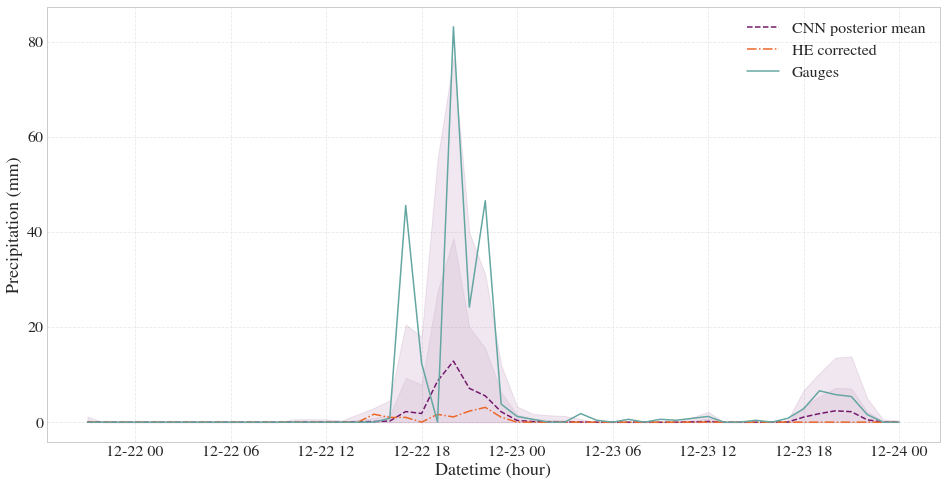

In [48]:
plotGaugeTimeseries(429,500,552) # Xerém

In [49]:
def plotExample(interval_length=48):
    ex_gauge = np.random.randint(0,len(combined.location))
    ex_time = np.random.randint(0,len(combined.time)-interval_length)
    print(ex_gauge, ex_time)
    gauge_vals = combined.gauge_precip[ex_time:ex_time+interval_length, ex_gauge]
    if np.isnan(gauge_vals).any():
        plotExample()
    else:
        plotGaugeTimeseries(ex_gauge,ex_time,ex_time+interval_length)

232 576


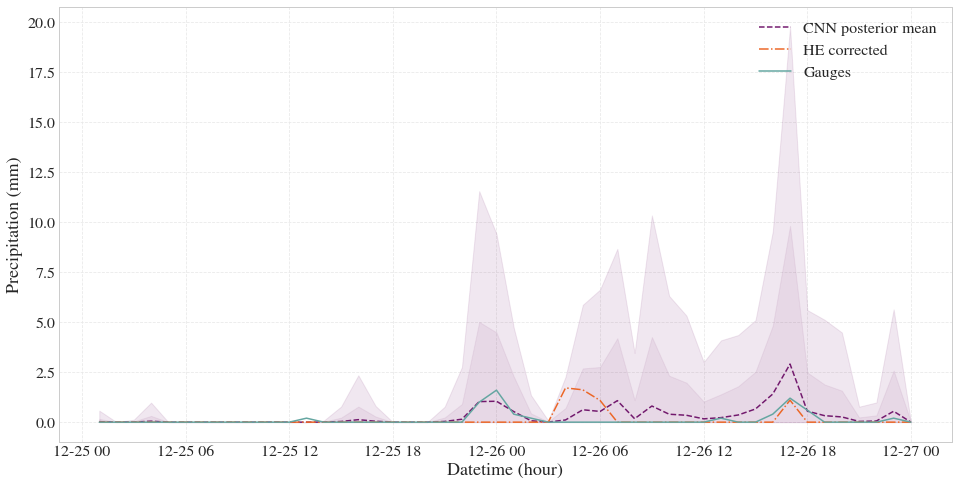

In [50]:
plotExample()

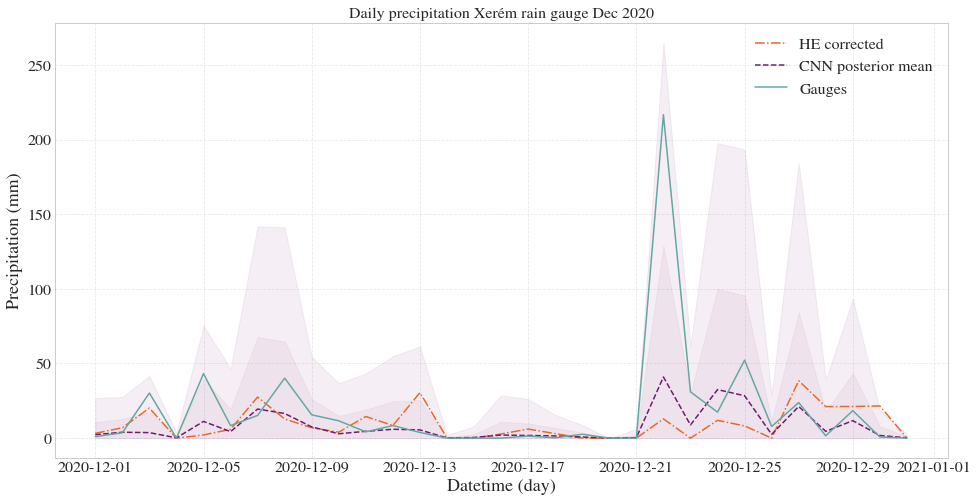

In [51]:

ind = 429
daym = combined.copy()
daym = daym.resample(time='D').sum()
fig, ax = plt.subplots(figsize=(16,8))
#plt.plot(daym.time, daym.mlp_posterior_mean[:, ind], label='mlp')
#ax.plot(daym.time, daym.HE_precip[:, ind], label='HE', color='#e6e6e6')
ax.fill_between(daym.time, daym['xception_Q0.99'][:, ind], alpha=0.07,
                color=setup.variable_dict['xception_posterior_mean']['color'])
ax.fill_between(daym.time, daym['xception_Q0.95'][:, ind], alpha=0.05, 
                color=setup.variable_dict['xception_posterior_mean']['color'])

ax.plot(daym.time, daym.HE_precip_corr[:, ind], label=setup.variable_dict['HE_precip_corr']['label'], 
        linestyle='dashdot',
        color=setup.variable_dict['HE_precip_corr']['color'])
ax.plot(daym.time, daym.xception_posterior_mean[:, ind], 
        label=setup.variable_dict['xception_posterior_mean']['label'],
        linestyle='dashed',
        color=setup.variable_dict['xception_posterior_mean']['color'])
ax.plot(daym.time, daym.gauge_precip[:, ind], label=setup.variable_dict['gauge_precip']['label'], 
        color=setup.variable_dict['gauge_precip']['color'])

ax.grid(True,which="both",ls="--",c=setup.color_grid)
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Datetime (day)')
ax.set_title('Daily precipitation Xerém rain gauge Dec 2020')
ax.legend()

### By region

['N', 'SE', 'CW', 'S', 'NE']
100
149
115
95
150


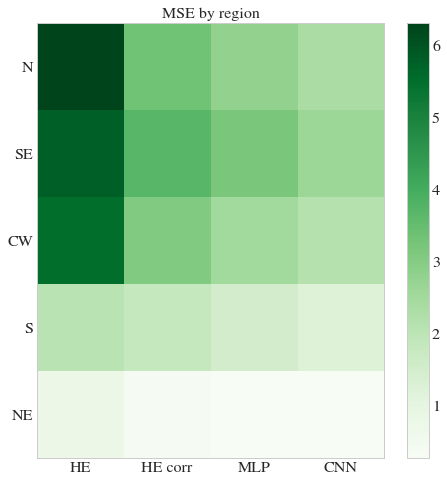

In [52]:
reg = ['N', 'SE', 'CW', 'S', 'NE'] #np.unique(metadata.region)
print(reg)
mse_by_region = np.zeros((len(reg),4))

for i in range(len(reg)):
    locs = list(metadata.index[metadata.region == reg[i]])
    print(len(locs))
    selection = combined.copy().isel(location=locs)
    mse_by_region[i,0] = MSE('gauge_precip', 'HE_precip', selection, mask[:,locs])
    mse_by_region[i,1] = MSE('gauge_precip', 'HE_precip_corr', selection, mask[:,locs])
    mse_by_region[i,2] = MSE('gauge_precip', 'mlp_posterior_mean', selection, mask[:,locs])
    mse_by_region[i,3] = MSE('gauge_precip', 'xception_posterior_mean', selection, mask[:,locs])
    
fig, ax = plt.subplots(figsize=(8,8))
m = ax.imshow(mse_by_region, cmap='Greens')
ax.set_yticks(list(range(len(reg))))
ax.set_yticklabels(reg)
mods = ['HE', 'HE corr', 'MLP', 'CNN']
ax.set_xticks(list(range(len(mods))))
ax.set_xticklabels(mods)
ax.set_title('MSE by region')
ax.grid(False)
fig.colorbar(m)
plt.show()

In [53]:
dat = combined.HE_precip_corr.values[mask==0].flatten()
print('unique values in gauge data:', np.unique(dat))
print(np.min(dat), np.max(dat))

unique values in gauge data: [0.00000000e+00 4.84166667e-02 5.81000000e-02 ... 3.63790000e+01
 4.24810417e+01 5.08737500e+01]
0.0 50.87375


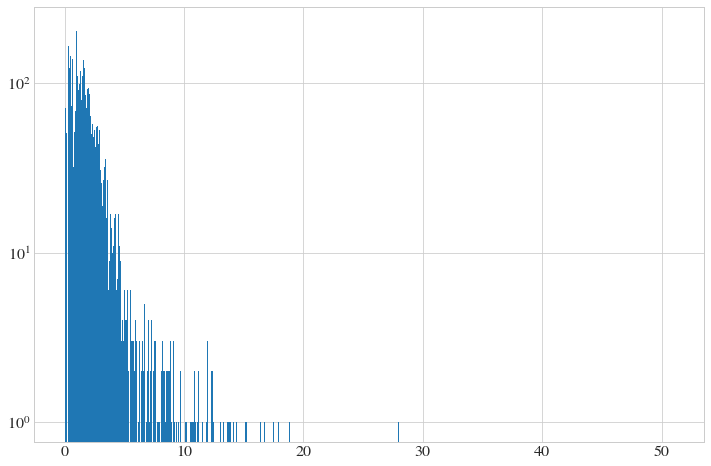

In [54]:
HE_bins=np.linspace(0,51,5001)
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(dat[dat>0.0], bins=HE_bins)
ax.set_yscale('log')

In [55]:
HE_freqs, _ = np.histogram(dat[dat>0.0], bins=HE_bins)

In [56]:
HE_bins[np.argmax(HE_freqs)]

1.0098

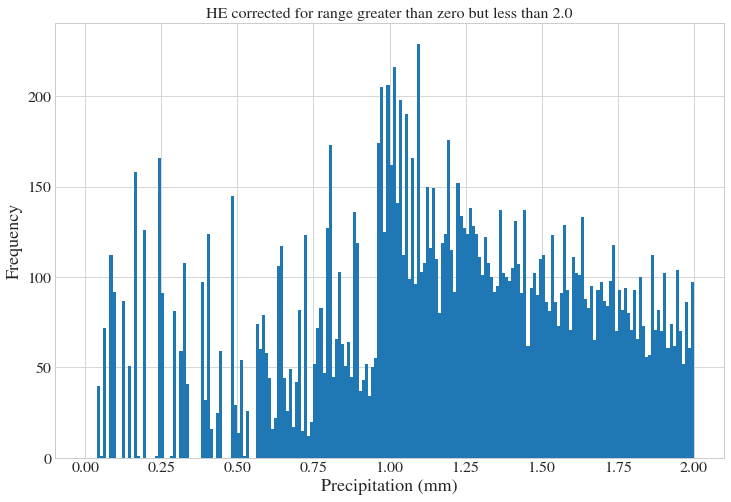

In [57]:
HE_bins=np.linspace(0,2,201)
fig, ax = plt.subplots(figsize=(12,8))
ax.hist(dat[dat>0.0], bins=HE_bins)
#ax.set_yscale('log')
ax.set_ylabel('Frequency')
ax.set_xlabel('Precipitation (mm)')
ax.set_title('HE corrected for range greater than zero but less than 2.0')
plt.show()